In [24]:
import pandas as pd
import numpy as np 
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.13.0


In [25]:
train_dir = Path('train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [26]:
print(train_filepaths)

[WindowsPath('train/apple/Image_1.jpg'), WindowsPath('train/apple/Image_10.jpg'), WindowsPath('train/apple/Image_16.jpg'), WindowsPath('train/apple/Image_17.jpg'), WindowsPath('train/apple/Image_18.jpg'), WindowsPath('train/apple/Image_19.jpg'), WindowsPath('train/apple/Image_2.jpg'), WindowsPath('train/apple/Image_20.jpg'), WindowsPath('train/apple/Image_21.jpg'), WindowsPath('train/apple/Image_23.jpg'), WindowsPath('train/apple/Image_24.jpg'), WindowsPath('train/apple/Image_25.jpg'), WindowsPath('train/apple/Image_26.jpg'), WindowsPath('train/apple/Image_27.jpg'), WindowsPath('train/apple/Image_28.jpg'), WindowsPath('train/apple/Image_3.jpg'), WindowsPath('train/apple/Image_31.jpg'), WindowsPath('train/apple/Image_32.jpg'), WindowsPath('train/apple/Image_33.jpg'), WindowsPath('train/apple/Image_34.jpg'), WindowsPath('train/apple/Image_36.jpg'), WindowsPath('train/apple/Image_37.jpg'), WindowsPath('train/apple/Image_38.jpg'), WindowsPath('train/apple/Image_39.jpg'), WindowsPath('train

In [27]:
test_dir = Path('test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [28]:
val_dir = Path('validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [29]:
 str(train_filepaths[1]).split("\\")

['train', 'apple', 'Image_10.jpg']

In [30]:
def image_processing(filepath):

    
    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    df = pd.concat([filepath, labels], axis=1)
    
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [31]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [32]:
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels {train_df.Label.unique()}')

Number of pictures: 2884

Number of different labels: 36

Labels ['apple' 'cabbage' 'orange' 'soy beans' 'garlic' 'tomato' 'pear' 'spinach'
 'eggplant' 'corn' 'potato' 'watermelon' 'sweetcorn' 'raddish' 'carrot'
 'beetroot' 'pomegranate' 'chilli pepper' 'sweetpotato' 'cucumber'
 'grapes' 'lettuce' 'bell pepper' 'turnip' 'banana' 'capsicum' 'paprika'
 'cauliflower' 'pineapple' 'jalepeno' 'peas' 'ginger' 'onion' 'mango'
 'kiwi' 'lemon']


In [33]:
train_df.head(5)

,Filepath,Label
0,train\apple\Image_31.jpg,apple
1,train\cabbage\Image_30.jpg,cabbage
2,train\orange\Image_67.jpg,orange
3,train\soy beans\Image_71.jpg,soy beans
4,train\garlic\Image_12.jpg,garlic


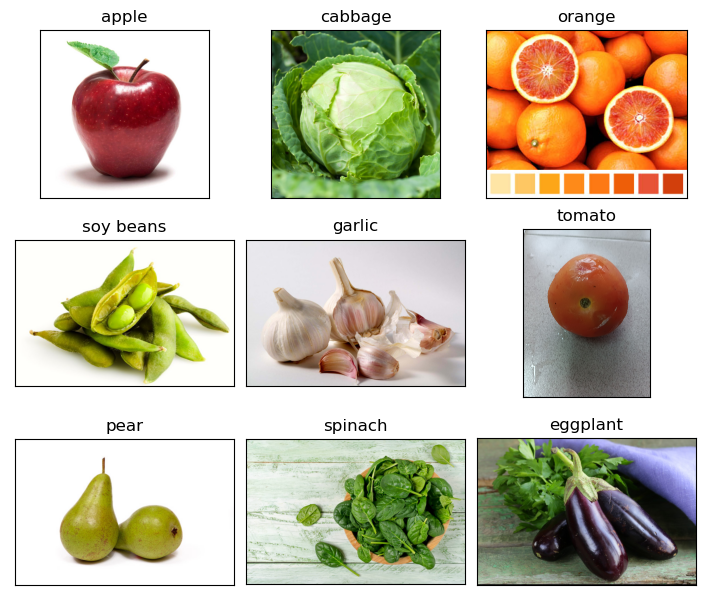

In [34]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 6), 
                         subplot_kw={'xticks': [],'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [35]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [36]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2884 validated image filenames belonging to 36 classes.


In [37]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 346 validated image filenames belonging to 36 classes.


In [38]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 343 validated image filenames belonging to 36 classes.


In [39]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
91/91 [==============================] - 264s 3s/step - loss: 1.7404 - accuracy: 0.5191 - val_loss: 0.4931 - val_accuracy: 0.8295
Epoch 2/20
91/91 [==============================] - 215s 2s/step - loss: 0.5583 - accuracy: 0.8145 - val_loss: 0.2729 - val_accuracy: 0.9104
Epoch 3/20
39/91 [===========>..................] - ETA: 1:49 - loss: 0.3178 - accuracy: 0.9014

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    print(answer)
    print(answer.max())
    print("bre")
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
img = output('img23.jpg')
import matplotlib.image as mpimg
img2 = mpimg.imread('img23.jpg')
plt.imshow(img2)
print(img)

In [ ]:
tf.keras.models.save_model(model, 'model.pbtxt')

converter = tf.lite.TFLiteConverter.from_keras_model(model=model)

model_tflite = converter.convert()

open("GrocRecogModel.tflite","wb").write(model_tflite)

In [ ]:
import tensorflow as tf
test_loss, test_accuracy = model.evaluate(test_images, verbose=1)

print(f'Test accuracy: {test_accuracy}')

In [ ]:
import tensorflow as tf

# Convert the model
def convert(dir):
    converter = tf.lite.TFLiteConverter.from_saved_model(dir) 
    tflite_model = converter.convert()
    return tflite_model


tflite_model = convert("<my_path>/models/model_5022022")

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)